## Access Station Wireless Sensor Network Delayec QC (Parquet)
This Jupyter notebook demonstrates how to access and plot station_wireless_sensor_network_delayec_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/4260aa0a-0d0a-4dd0-9ebc-74d2bf937e21).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/station_wireless_sensor_network_delayec_qc.ipynb).


In [1]:
dataset_name = "station_wireless_sensor_network_delayec_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 1.18 s, sys: 173 ms, total: 1.36 s
Wall time: 17.4 s


In [4]:
aodn_dataset.dataset.partitioning.schema

site_code: string
polygon: string
timestamp: int32
aims_channel_id: int32

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value))  # showing a subset only

['OTIRP3', 'DAVSF3', 'HIRP1', 'OISF2', 'LIZWS', 'HISF4', 'OTIRP2', 'HIRP5', 'OIRP1', 'DAVSF4', 'LIZSF1', 'OTIWS', 'MRYSF1', 'OIRP2', 'OIRP3', 'DAVSF2', 'HISF1', 'DAVBSE', 'LIZSF2', 'OISF1', 'HIRP4', 'OTIBSE', 'HIRP2', 'OTIRP1', 'HISF5', 'HIRP3', 'LIZSF3', 'LIZSF4', 'DAVSF5', 'HIRP7', 'DAVSF1', 'HIRP6', 'HIRP8', 'HISF2', 'HISF3', 'LIZRP2', 'RIBSF1', 'MYRWS', 'HIWS']
CPU times: user 38.7 ms, sys: 3.87 ms, total: 42.6 ms
Wall time: 39.9 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


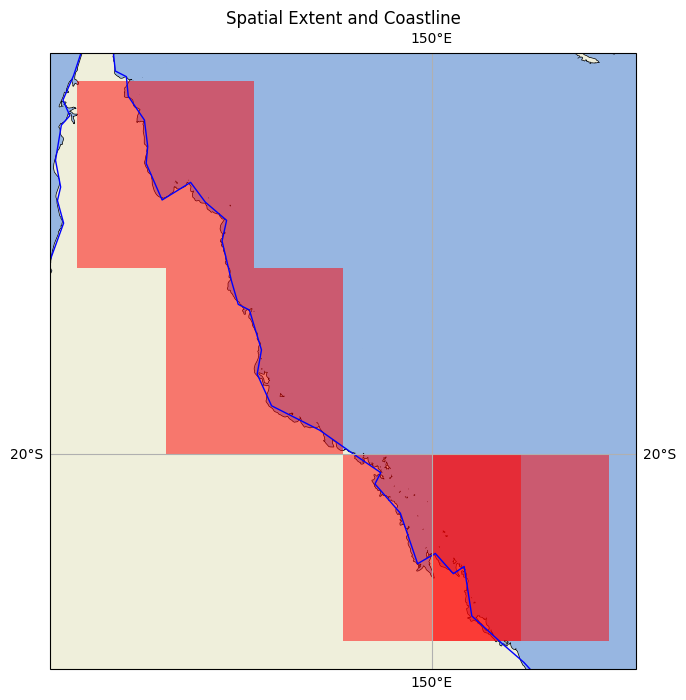

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 1.82 s, sys: 449 ms, total: 2.27 s
Wall time: 15.3 s


(Timestamp('2008-11-18 09:00:00'), Timestamp('2023-06-18 22:00:00'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-10-29 14:54:47,409 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/station_wireless_sensor_network_delayec_qc.parquet


{'LATITUDE': {'type': 'double',
  'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'reference_datum': 'geographical coordinates, WGS84 projection'},
 'LONGITUDE': {'type': 'double',
  'long_name': 'longitude',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'reference_datum': 'geographical coordinates, WGS84 projection'},
 'NOMINAL_DEPTH': {'type': 'double',
  'long_name': 'nominal depth',
  'standard_name': 'depth',
  'units': 'metres',
  'positive': 'down',
  'axis': 'Z',
  'reference_datum': 'sea surface',
  'valid_min': -10.0,
  'valid_max': 30.0},
 'DEPTH': {'type': 'double',
  'long_name': 'actual depth',
  'standard_name': 'depth',
  'units': 'metres',
  'ancillary_variables': 'DEPTH_quality_control',
  'sensor_depth': 5.2,
  'reference_datum': 'sea surface',
  'positive': 'down',
  'valid_min': -10.0,
  'valid_ma

# Data Query and Plot

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2010-01-01', 
                           date_end='2015-01-01',
                           scalar_filter={'site_code': "LIZWS"})
df.info()

2025-10-29 14:55:32,553 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/station_wireless_sensor_network_delayec_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650871 entries, 0 to 3650870
Data columns (total 53 columns):
 #   Column                                Dtype          
---  ------                                -----          
 0   LATITUDE                              float64        
 1   LONGITUDE                             float64        
 2   NOMINAL_DEPTH                         float64        
 3   TIME                                  datetime64[ns] 
 4   DOWN_PHOTOSYNTH_FLUX                  float32        
 5   DOWN_PHOTOSYNTH_FLUX_quality_control  float32        
 6   filename                              object         
 7   DEPTH                                 float64        
 8   DEPTH_quality_control                 float64        
 9   PRES_REL                              float32        
 10  PRES_REL_quality_control              float32        
 11  TEMP                                  float32        
 12  TEMP_quality_control                  float32        
 1

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.

# Uncomment if needed
# df.aodn.download_as_csv()

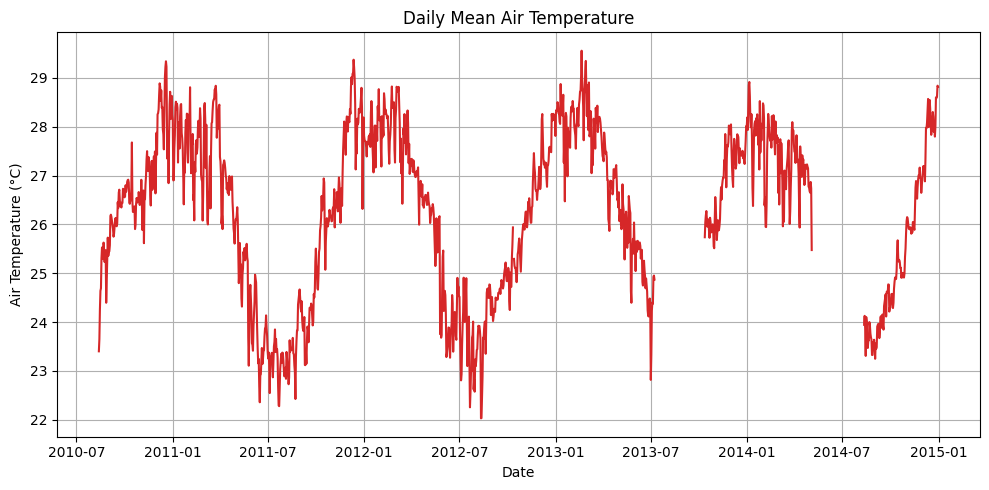

In [11]:
import matplotlib.pyplot as plt

df_air = df.dropna(subset=['AIRT']).sort_values('TIME')
df_air = df_air.set_index('TIME')

# Downsample to daily mean
daily_air = df_air['AIRT'].resample('1D').mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_air.index, daily_air, color='tab:red')
plt.xlabel("Date")
plt.ylabel("Air Temperature (°C)")
plt.title("Daily Mean Air Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


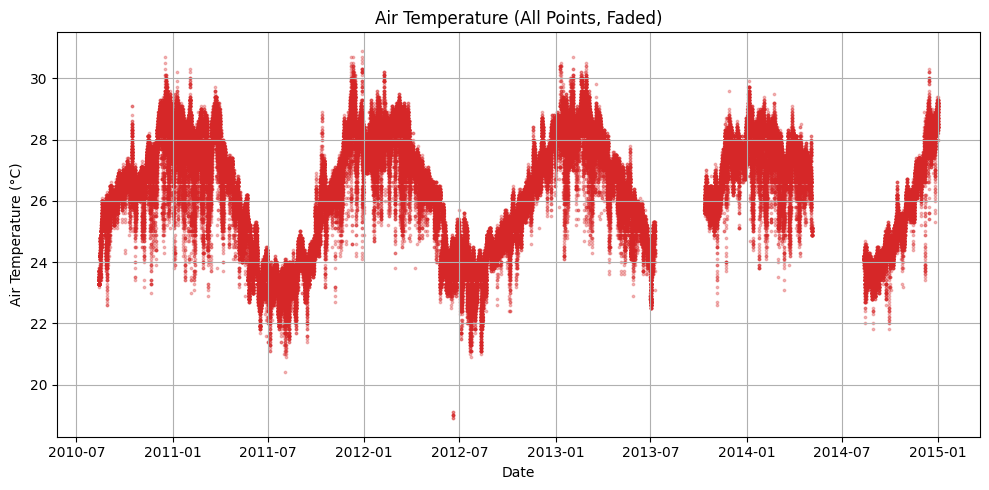

In [12]:
import matplotlib.pyplot as plt

df_air = df.dropna(subset=['AIRT']).sort_values('TIME')
df_air = df_air.set_index('TIME')

plt.figure(figsize=(10, 5))
plt.scatter(df_air.index, df_air['AIRT'], s=3, alpha=0.3, color='tab:red')
plt.xlabel("Date")
plt.ylabel("Air Temperature (°C)")
plt.title("Air Temperature (All Points, Faded)")
plt.grid(True)
plt.tight_layout()
plt.show()


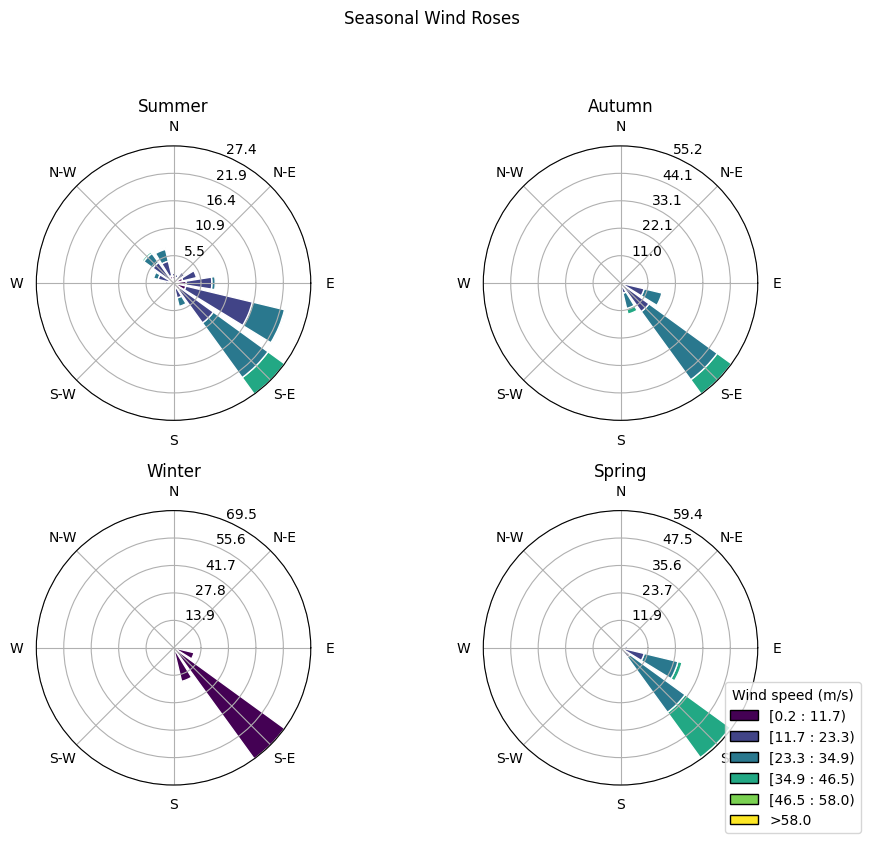

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from windrose import WindroseAxes

dir_col = 'WDIR_30min'
spd_col = 'WSPD_30min'

# Drop NaNs, sort by time
dir_df = df[['TIME', dir_col]].dropna().sort_values('TIME')
spd_df = df[['TIME', spd_col]].dropna().sort_values('TIME')

# Match nearest direction/speed in time ---
matched = pd.merge_asof(spd_df, dir_df, on='TIME', direction='nearest', tolerance=pd.Timedelta('15min'))
matched = matched.dropna()
matched = matched[(matched[dir_col] >= 0) & (matched[dir_col] <= 360)]

# Add SEASON column ---
def get_season(month):
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

matched['SEASON'] = matched['TIME'].dt.month.map(get_season)

# Plot one wind rose per season ---
seasons = ["Summer", "Autumn", "Winter", "Spring"]
fig, axes = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': 'windrose'})
axes = axes.flatten()

for ax, season in zip(axes, seasons):
    subset = matched[matched['SEASON'] == season]
    if subset.empty:
        ax.text(0.5, 0.5, f"No data\n({season})", ha='center', va='center')
        continue

    ax.bar(subset[dir_col], subset[spd_col],
           normed=True, opening=0.8, edgecolor='white')
    ax.set_title(season)

axes[-1].legend(title="Wind speed (m/s)", loc='lower right', bbox_to_anchor=(1.4, -0.2))
plt.suptitle("Seasonal Wind Roses", y=1.05)
plt.tight_layout()
plt.show()
